# Data Sourcing 

* Get EOPatches From Different Locations using GeoJsons
* Split Each EOPatch into 256 x 256 boxes and store them as x_train and y_train

In [2]:
!sentinelhub.config --show

/bin/bash: sentinelhub.config: command not found


In [3]:
! pip install eo-learn

     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 10.5MB 28.6MB/s 
     |████████████████████████████████| 18.3MB 152kB/s 
     |████████████████████████████████| 42.9MB 144kB/s 
     |████████████████████████████████| 133kB 56.5MB/s 
     |████████████████████████████████| 133kB 59.9MB/s 
     |████████████████████████████████| 194kB 58.4MB/s 
     |████████████████████████████████| 14.5MB 190kB/s 
     |████████████████████████████████| 972kB 50.0MB/s 
     |████████████████████████████████| 4.8MB 48.2MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 7.1MB 47.1MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 6.5MB 46.4MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 14.8MB 226kB/s 
     |████████████████████████████████| 1.4MB 44.0MB/s 
     |████████████████████████████████| 143kB 47.2MB/s

In [4]:
# import libraries and modules

import os
import datetime 
from os import path as op
import itertools

from eolearn.io import *
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, SaveToDisk, OverwritePermission, SaveTask
from sentinelhub import BBox, CRS, BBoxSplitter, MimeType, ServiceType, DataCollection

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import geopandas

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from google.colab import drive
K.clear_session()

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Select the time series from which you are going to extract your median picture, if you choose a low value you may get an error of a place without an image in that time. 

As well, here you define the `img_width` and `img_height` that will go inside x_train and y_train. A low value is okay to not give a huge picture to our model. 

In [5]:
# global image request parameters
#time_interval = ('2017-01-01', '2017-12-31')
time_interval = ('2017-01-01', '2017-12-31')
img_width = 256
img_height = 256
maxcc = 0.2

## Generate EOPatches for each geojson region

In [6]:
places = ['eastern_france']
placesDict = {place: {} for place in places} 

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!ls "/content/gdrive/My Drive/co2go"

 eopatches  'Project Guidelines.gdoc'
 geojsons    TCD_2018_010m_E50N21_03035_v020.tif


In [9]:
# get the AOI and split into bboxes

crs = CRS.UTM_31N

for place in places:

    path_file = f'/content/gdrive/My Drive/co2go/geojsons/{place}.geojson'

    aoi = geopandas.read_file(path_file)
    aoi = aoi.to_crs(crs=crs.pyproj_crs())
    placesDict[place]['aoi'] = aoi

    aoi_shape = aoi.geometry.values[-1]
    placesDict[place]['aoi_shape'] = aoi_shape
    

    W = (aoi_shape.bounds[2] - aoi_shape.bounds[0])
    H = (aoi_shape.bounds[3] - aoi_shape.bounds[1])
    
    placesDict[place]['W'] = W
    placesDict[place]['H'] = H

    print(f'The dimension of the {place} is {W} x {H} m2')


The dimension of the eastern_france is 49971.145568380714 x 36527.54762531631 m2


In [10]:
placesDict

{'eastern_france': {'H': 36527.54762531631,
  'W': 49971.145568380714,
  'aoi':                                             geometry
  0  POLYGON ((575854.526 5277548.501, 625359.720 5...,
  'aoi_shape': <shapely.geometry.polygon.Polygon at 0x7f25e8d16208>}}

In [11]:
# Write here whatever height and width you want each individual place in pixels (these cannot be bigger than 2500)

place = 'eastern_france'

w = 500
h = 500

# 
placesDict[place]['x_boxes'] = round(placesDict[place]['W'] / (w*10))
placesDict[place]['y_boxes'] = round(placesDict[place]['H'] / (h*10)) 

x_boxes = placesDict[place]['x_boxes']
y_boxes = placesDict[place]['y_boxes']

print(f"You will create a grid {x_boxes} * {y_boxes} = {x_boxes*y_boxes} boxes of size {round(placesDict[place]['H']/(y_boxes*10))} x {round(placesDict[place]['W']/(x_boxes*10))} for {place}")

You will create a grid 10 * 7 = 70 boxes of size 522 x 500 for eastern_france


In [12]:
# Split the AOI into bboxes
for place in places:
    aoi_shape = placesDict[place]['aoi_shape']
    x_boxes = placesDict[place]['x_boxes']
    y_boxes = placesDict[place]['y_boxes']
    placesDict[place]['bbox_splitter'] = BBoxSplitter([aoi_shape], crs, (x_boxes, y_boxes))

In [13]:
# set raster_value conversions for our Geopedia task
# see more about how to do this here:

raster_value = {
    '0%': (0, [0, 0, 0, 0]),
    '10%': (1, [163, 235,  153, 255]),
    '30%': (2, [119, 195,  118, 255]),
    '50%': (3, [85, 160, 89, 255]),
    '70%': (4, [58, 130, 64, 255]),
    '90%': (5, [36, 103, 44, 255])
}


import matplotlib as mpl

tree_cmap = mpl.colors.ListedColormap(['#F0F0F0', 
                                       '#A2EB9B', 
                                       '#77C277', 
                                       '#539F5B', 
                                       '#388141', 
                                       '#226528'])
tree_cmap.set_over('white')
tree_cmap.set_under('white')

bounds = np.arange(-0.5, 6, 1).tolist()
tree_norm = mpl.colors.BoundaryNorm(bounds, tree_cmap.N)

In [14]:
# create a task for calculating a median pixel value
class MedianPixel(EOTask):
    """
    The task returns a pixelwise median value from a time-series and stores the results in a 
    timeless data array.
    """
    def __init__(self, feature, feature_out):
        self.feature_type, self.feature_name = next(self._parse_features(feature)())
        self.feature_type_out, self.feature_name_out = next(self._parse_features(feature_out)())

    def execute(self, eopatch):
        eopatch.add_feature(self.feature_type_out, self.feature_name_out, 
                            np.median(eopatch[self.feature_type][self.feature_name], axis=0))
        return eopatch

In [15]:
# initialize tasks
# task to get S2 L2A images

input_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L2A, 
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=10, 
                                     maxcc=0.2, 
                                     bands=['B04', 'B03', 'B02'], 
                                     time_difference=datetime.timedelta(hours=2),
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA')]
                                    )
geopedia_data = AddGeopediaFeature((FeatureType.MASK_TIMELESS, 'TREE_COVER'), 
                                   layer='ttl2275', theme='QP', raster_value=raster_value)
# task to compute median values
get_median_pixel = MedianPixel((FeatureType.DATA, 'BANDS'), 
                               feature_out=(FeatureType.DATA_TIMELESS, 'MEDIAN_PIXEL'))
# task to save to disk
save = SaveTask(op.join('..', '..','raw_data', 'eopatch'), 
                  overwrite_permission=OverwritePermission.OVERWRITE_PATCH, 
                  compress_level=2)

In [16]:
# initialize workflow
workflow = LinearWorkflow(input_task, geopedia_data, get_median_pixel, save)

In [17]:
# use a function to run this workflow on a single bbox
def execute_workflow(index):
    bbox = bbox_splitter.bbox_list[index]
    info = bbox_splitter.info_list[index]
    
    patch_name = f"{place}_eopatch_{index}_row-{info['index_x']}_col-{info['index_y']}"
    
    results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                                save:{'eopatch_folder':patch_name}
                               })
    return list(results.values())[-1]
    del results 

In [18]:
!sentinelhub.config --show

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
{
  "instance_id": "",
  "sh_client_id": "",
  "sh_client_secret": "",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5,
  "download_timeout_seconds": 120,
  "number_of_download_processes": 1
}
Configuration file location: /usr/local/lib/python3.6/dist-packages/senti

In [19]:
!sentinelhub.config --instance_id 310cf3f7-8427-45db-bd2c-2a54dc98f58d

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
The value of parameter 'instance_id' was updated to '310cf3f7-8427-45db-bd2c-2a54dc98f58d'


In [20]:
!sentinelhub.config --sh_client_id 5b967d60-8cb8-4a2e-912d-851381973b54 --sh_client_secret "v}-&&L?:j~g:yD2g+>TxgTB8gf<{K6w%T~NJldGc"

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
The value of parameter 'sh_client_id' was updated to '5b967d60-8cb8-4a2e-912d-851381973b54'
The value of parameter 'sh_client_secret' was updated to 'v}-&&L?:j~g:yD2g+>TxgTB8gf<{K6w%T~NJldGc'


In [21]:
%%time

# run over multiple bboxes and upload eopatch

#for place in places:
#    bbox_splitter = placesDict[place]['bbox_splitter']
#    subset_idx = len(bbox_splitter.bbox_list)
#    pbar = tqdm(total=subset_idx)
#    for idx in range(0, subset_idx):
#        patch = execute_workflow(idx)
#        pbar.update(1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [22]:
from math import floor

def split_eopatch(patch, img_height=256, img_width=256):
    x_train_raw = []
    y_train_raw = []
    
    
    mp = patch.data_timeless['MEDIAN_PIXEL']
    tc = patch.mask_timeless['TREE_COVER']
    
    patch_height = mp.shape[0]
    patch_width = mp.shape[1]
    
    mini_patch_rows = floor(patch_height/img_height)
    mini_patch_columns = floor(patch_width/img_width)

    for i in range(mini_patch_rows):
        for j in range(mini_patch_columns):
            x = mp[ i*img_height:(i*img_height)+img_height , j*img_width:(j*img_width)+img_width, :]
            y = tc[ i*img_height:(i*img_height)+img_height , j*img_width:(j*img_width)+img_width, :]
#            if i == 0:
#                pass
#            elif i == (mini_patch_rows - 1):
#                pass 
#            else:
            x_train_raw.append(x)
            y_train_raw.append(y)

    x_train_raw = np.array(x_train_raw)
    y_train_raw = np.array(y_train_raw)
    
    return x_train_raw, y_train_raw

In [23]:
import os
files = os.listdir('../content/gdrive/My Drive/co2go/eopatches/')
files = [file for file in files if 'eopatch' in file]
print(len(files))

6


In [24]:
# Iterate over all eopatches, split them into 256x256 boxes, add them into one big array
import os

files = os.listdir('../content/gdrive/My Drive/co2go/eopatches/')
files = [file for file in files if 'eopatch' in file]

for index, file in enumerate(files):
    patch = EOPatch.load(f'../content/gdrive/My Drive/co2go/eopatches/{file}')
    x, y = split_eopatch(patch)
    
    if index == 0:
        x_train_raw = x
        y_train_raw = y
    else: 
        x_train_raw = np.concatenate((x_train_raw, x))
        y_train_raw = np.concatenate((y_train_raw, y))

    print(f'{x_train_raw.shape[0]} images' )
        
x_train_raw.shape, y_train_raw.shape

42 images
84 images
126 images
168 images
210 images
252 images


((252, 256, 256, 3), (252, 256, 256, 1))

In [25]:
y_train_raw.shape

(252, 256, 256, 1)

ValueError: ignored

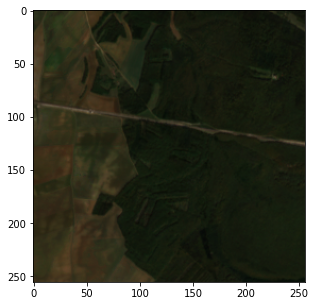

In [26]:
id = 40

plt.figure(figsize=(5,5))
plt.imshow(2.5*x_train_raw[id])
plt.plot(y_train_raw[id], vmin=0, vmax=5, alpha=.5, cmap=tree_cmap)
plt.colorbar()

In [ ]:
x_train_raw.shape

In [ ]:
y_train_raw.shape

In [ ]:
np.unique(y_train_raw[0])

In [27]:
img_mean = np.mean(x_train_raw, axis=(0, 1, 2))
img_std = np.std(x_train_raw, axis=(0, 1, 2))
x_train_mean = x_train_raw - img_mean
x_train = x_train_mean - img_std

train_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180)

y_train = to_categorical(y_train_raw, len(raster_value))

In [28]:
# Model setup
#from https://www.kaggle.com/lyakaap/weighing-boundary-pixels-loss-script-by-keras2
# weight: weighted tensor(same shape with mask image)

def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
            y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + \
    weighted_dice_loss(y_true, y_pred, weight)
    return loss

def unet(input_size):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(len(raster_value), 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = weighted_bce_dice_loss, 
                  metrics = ['accuracy'])

    return model

model = unet(input_size=(256, 256, 3))

In [29]:
# Fit the model
batch_size = 16
model.fit_generator(
        train_gen.flow(x_train, y_train, batch_size=batch_size),
#        steps_per_epoch=len(x_train),
        epochs=20,
        verbose=1)
model.save(op.join('model.h5'))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
16/16 [==============================] - 17s 1s/step - loss: 1.2637 - accuracy: 0.4178
Epoch 2/20
16/16 [==============================] - 13s 843ms/step - loss: 1.0742 - accuracy: 0.5733
Epoch 3/20
16/16 [==============================] - 14s 846ms/step - loss: 1.0485 - accuracy: 0.5765
Epoch 4/20
16/16 [==============================] - 14s 854ms/step - loss: 1.0185 - accuracy: 0.5766
Epoch 5/20
16/16 [==============================] - 14s 859ms/step - loss: 1.0006 - accuracy: 0.5766
Epoch 6/20
16/16 [==============================] - 14s 863ms/step - loss: 1.0001 - accuracy: 0.5807
Epoch 7/20
16/16 [==============================] - 14s 870ms/step - loss: 0.9908 - accuracy: 0.5840
Epoch 8/20
16/16 [==============================] - 14s 876ms/step - loss: 0.9699 - accuracy: 0.6039
Epoch 9/20
16/16 [==============================] - 14s 881ms/step - loss: 0.9846 - accuracy: 0.5959
Epoch 10/20
16/16 

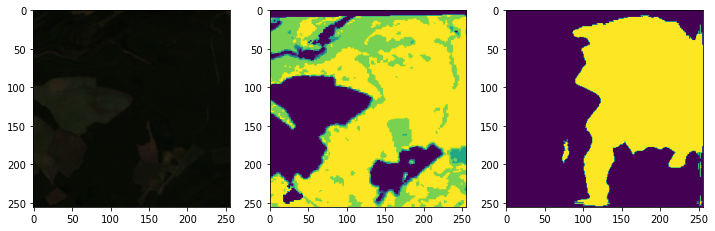

In [30]:
# plot one example (image, label, prediction)
idx = 4
p = np.argmax(model.predict(np.array([x_train[idx]])), axis=3)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(x_train_raw[idx])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(y_train_raw[idx][:,:,0])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(p[0])

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[9.81297714e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.87022857e-02]
 [9.09467024e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.05329764e-02]
 [8.77726439e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.22273561e-01]
 [7.80988766e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.19011234e-01]
 [5.09257899e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.02578596e-07 4.90741699e-01]
 [3.31901724e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.68098276e-01]]


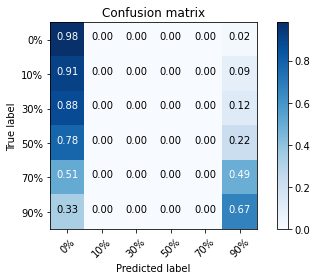

In [32]:
# show image confusion matrix
predictions = np.argmax(model.predict(x_train), axis=3)
cnf_matrix = confusion_matrix(y_train_raw.reshape(len(y_train_raw) * 256 * 256, 1), 
                              predictions.reshape(len(predictions) * 256 * 256, 1))
plot_confusion_matrix(cnf_matrix, raster_value.keys(), normalize=True)